In [68]:
import os
import ee
import warnings
import asf_search
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from hyp3_sdk import HyP3
import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.geometry import Polygon
warnings.simplefilter(action='ignore')

In [89]:
# Get the current working directory
current_directory = os.getcwd()

# Get the parent directory (one level up)
parent_directory = os.path.dirname(current_directory)

data_dir = os.path.join(parent_directory, 'data')
fig_dir = os.path.join(parent_directory, 'figures')

In [3]:
## fire perimeters

fnames = os.listdir(os.path.join(data_dir, 'bldg_destruction_pts_sample_fires'))

shps = [f for f in fnames if '.shp' in f and 'xml' not in f]
shp_paths = [os.path.join(data_dir, 'bldg_destruction_pts_sample_fires', f) for f in shps]

fire_gdfs = gpd.GeoDataFrame(pd.concat([gpd.read_file(f) for f in shp_paths]))

In [4]:
fire_gdfs = fire_gdfs.to_crs('EPSG:4326')

In [5]:
dates = []
for i, f in tqdm(fire_gdfs.iterrows()):
    if f['fire_name'] == 'MARSHALL':
        dates.append(pd.to_datetime('2021-12-31'))
    else:
        date_string = f"{f['fire_year']}-{f['fire_month']:02d}-{f['fire_day']:02d}"
        dates.append(pd.to_datetime(date_string))
    # except:
    #     print('bad dates')
    #     dates.append(np.nan)
    

54840it [00:22, 2384.54it/s]


In [6]:
fire_gdfs['dt'] = dates

In [7]:
fire_names = fire_gdfs['fire_name'].drop_duplicates()

In [8]:
fire_dates = fire_gdfs.groupby('fire_name').first()['dt']

In [9]:
## union points for each fire

bounding_boxes = []

for n in fire_names:
    pts = fire_gdfs[fire_gdfs['fire_name'] == n]
    minx, miny, maxx, maxy = pts.dissolve().bounds.values[0]
    geom_box = box(minx, miny, maxx, maxy)
    bounding_boxes.append(geom_box)

In [10]:
aoi_gdf = gpd.GeoDataFrame({'fire_name': fire_names.values, 'fire_date': fire_dates.values}, geometry = bounding_boxes)

In [56]:
intersecting_scene_ids = []
intersecting_scene_bounds = []

for i, f in tqdm(aoi_gdf.iterrows()):
    before_fire = (f['fire_date'] - pd.Timedelta(days = 12)).strftime('%Y-%m-%d')
    after_fire = (f['fire_date'] + pd.Timedelta(days = 12)).strftime('%Y-%m-%d')
    wkt = f.geometry.wkt
    search_results = asf_search.geo_search(start = before_fire, end = after_fire, 
                                           intersectsWith = wkt, platform=[asf_search.PLATFORM.SENTINEL1], 
                                           dataset = 'SENTINEL-1',
                                          processingLevel = 'SLC')

    fileIds = []
    geometries = []
    for r in search_results:
        geojson = r.geojson()
        coordinates = geojson['geometry']['coordinates'][0]
    
        # Create the Shapely Polygon from the coordinates
        polygon = Polygon(coordinates)
        geometries.append(polygon)
        fileIds.append(r.properties['fileID'])
        
    intersecting_scene_ids.append(fileIds)
    intersecting_scene_bounds.append(geometries)

6it [00:13,  2.24s/it]


In [57]:
aoi_gdf['s1_scene_ids'] = intersecting_scene_ids
aoi_gdf['s1_scene_bounds'] = intersecting_scene_bounds


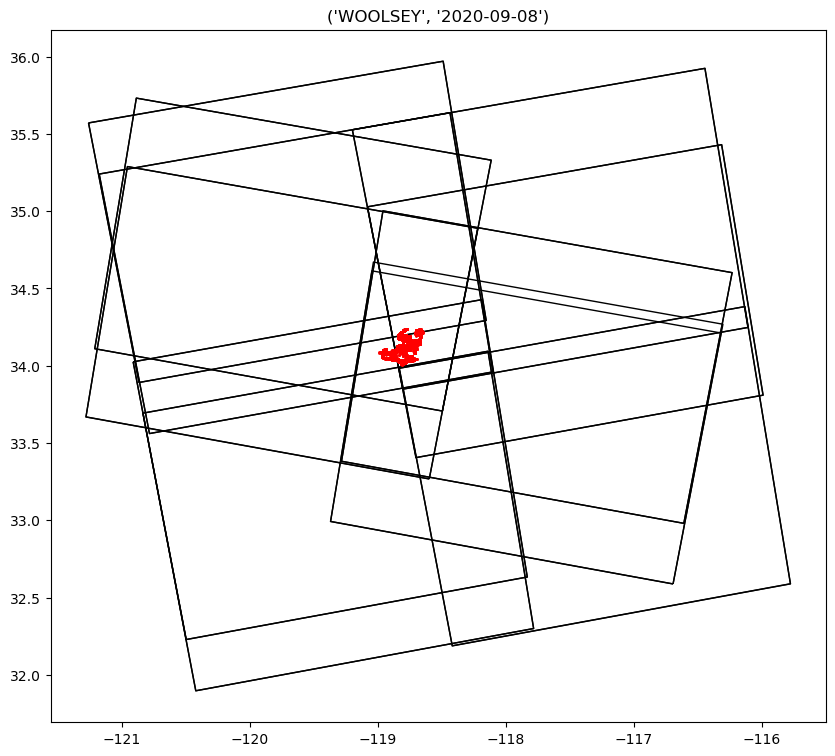

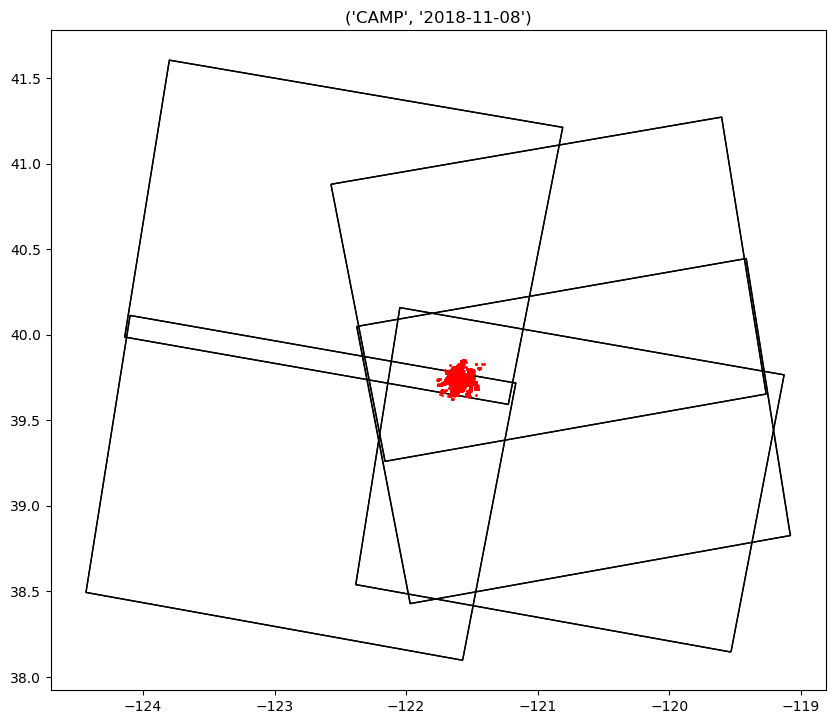

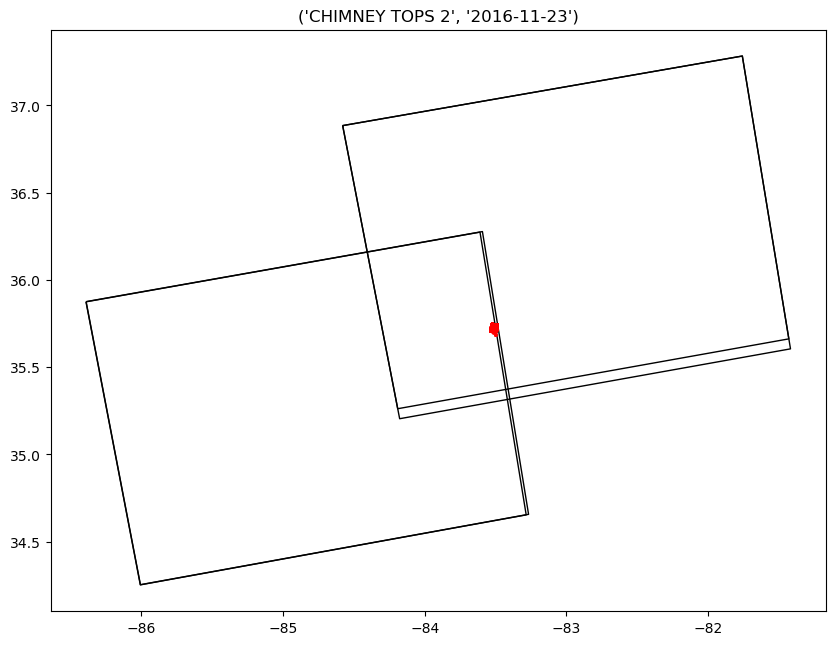

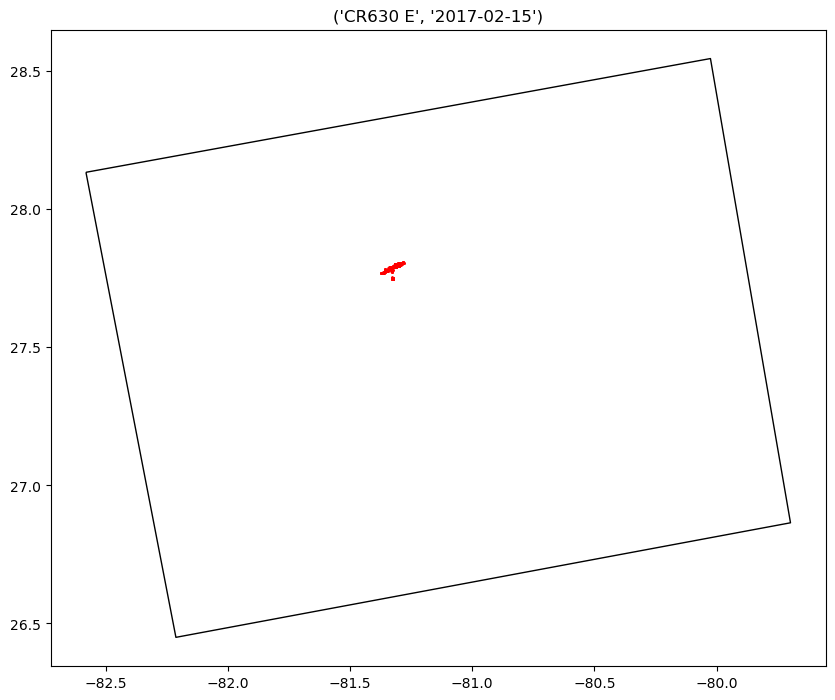

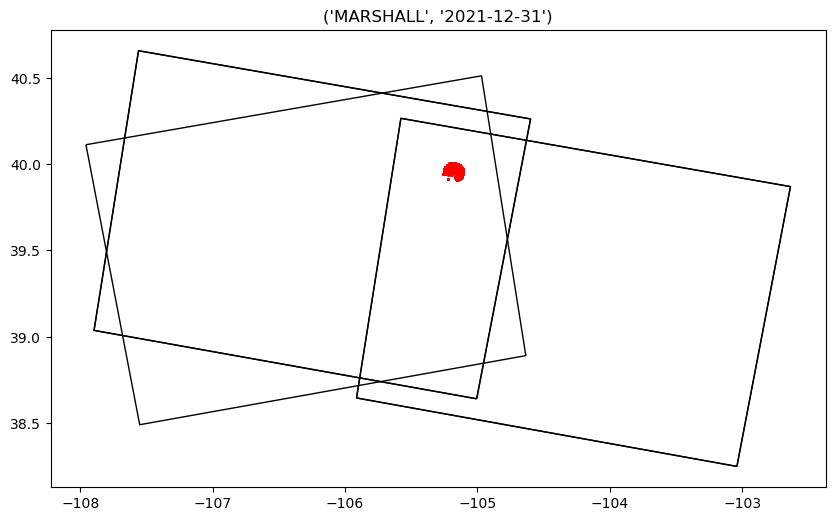

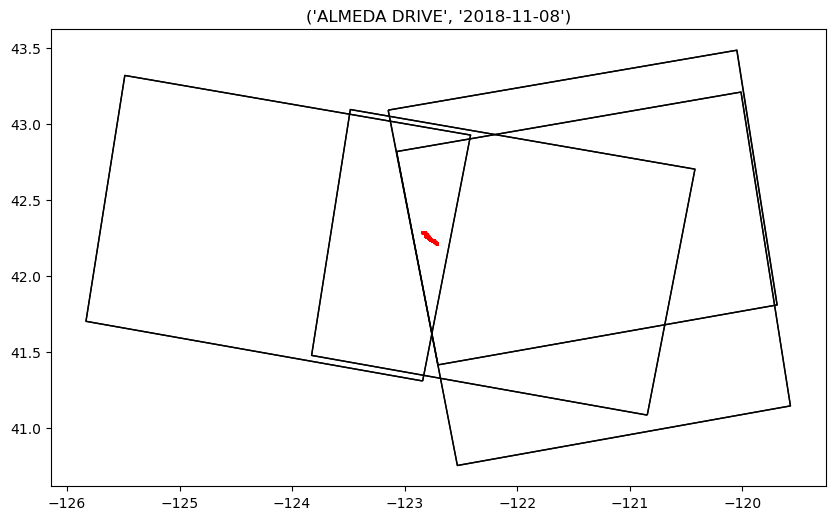

In [92]:
## for each fire, plot the bounding box, fire damage points, and S1 scene outlines and save to fig dir

for i, f in aoi_gdf.iterrows():
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))

    gpd.GeoSeries(f['s1_scene_bounds']).plot(ax = ax, facecolor = 'none', edgecolor = 'black')
    
    damage_points = fire_gdfs[fire_gdfs['fire_name'] == f['fire_name']]
    damage_points.plot(ax = ax, color = 'red', markersize = 1)
    ax.set_title(f"{f['fire_name'], f['fire_date'].strftime('%Y-%m-%d')}")

    plt.savefig(os.path.join(fig_dir, f"{f['fire_name']}.png"), dpi = 300)
    